### see https://code.visualstudio.com/docs/python/jupyter-support

In [1]:
# https://stackoverflow.com/questions/26545051/is-there-a-way-to-delete-created-variables-functions-etc-from-the-memory-of-th
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
dir();

# Phase noise of lasers

This is a demo for simulating the phase-noise of a laser (random walk). Details on the underlying theory can be found in, e.g., [Barry, J.R. and Lee, E.A., 'Performance of coherent optical receivers', Proceedings of the IEEE, vol. 78, no. 8, 1990] and [J. Franz, Optische Übertragungssysteme mit Überlagerungsempfang - Berechnung, Optimierung, Vergleich. Springer Verlag, 1988]


## Import required libraries

In [2]:
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
import numpy as np # print(np.version.version)
from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
import scipy.signal as signal
import math as m
import ipywidgets as widgets

plt.style.use('noelle.mplstyle')

## Set simulation defaults

In [3]:
# simulation parameters TODO: change M to total time frame T_total
M = 2**12    # (N_symb) no. of simulated modulation symbols (i.e., time steps) in each trial TODO: as widget
N = 2**5     # (N_trials) no. of differenet random walk trials TODO: as widget
LW = 1.e6    # laser linewidth [Hz] (Tx+LO) - TODO: as widget
Rs = 30.e9   # [Baud] symbol rate (TODO: as widget)?

## Some helper calculations

In [4]:
dt = 1/Rs   # [s] symbol duration = time step for discrete phase noise model (1 SpS)
T = M*dt    # [s] observation duration
t = np.arange(0, M)*dt # [s] time axis #Matlab: t = 0:dt:T-dt;

varPN = 2*m.pi*LW*dt; #[rad²] phase variance after time interval dt; proportional to linewidth and observation time [Barry1990]/eq.(112)
print('RMS phase deviation: {:1.3f} deg/symbol'.format(180/np.pi*np.sqrt(varPN))) #rmsDev = 180/pi*sqrt(varPN); # [degree/symbol] RMS phase deviation

RMS phase deviation: 0.829 deg/symbol


## Generate an ensemble of N phase noise (Wiener) processes

In [5]:
#np.random.seed(1) # TODO: configure as widget
phaseInc = m.sqrt(varPN)*np.random.normal(loc=0,scale=1,size=(M,N)); # [rad] Gaussian i.i.d. phase increments with variance varPN
phaseAcc = np.cumsum(phaseInc,0); # [rad] accumulated phase = random walk
phaseAcc = phaseAcc - phaseAcc[0,:]    # [rad] rotate all phase processes back to initial zero phase
#print(phaseAcc.shape) # print(phaseAcc[0,:].shape)
varMeas = np.var(phaseAcc,axis=1,ddof=1); # [rad²] estimated phase variance (with DOF=N-1) at every time instant accross all sampled random processes
#print(varMeas.shape)

## Instantanous frequency and PSD of phase noise

In [6]:
# see [Barry1990]/eqn.(107)ff
# Generation of sample (field) waveforms (no z-dep., i.e. z=0) to plot PSD of laser waveform (in equivalent baseband)
wc = 0*Rs/M*16 * 2*m.pi # [rad/s] laser carrier frequency offset 
Ps = 1e-3; # [W] laser output power
x = np.sqrt(Ps)*np.exp(1j*(wc*t[:,np.newaxis] + phaseAcc)); # [W] N sample waveform functions
# numpy array broadcasting: https://machinelearningmastery.com/broadcasting-with-numpy-arrays/

freq = fftshift(fftfreq(M, 1/Rs))           # [Hz] frequency vector (from  ~ -Rs/2 to ~ +Rs/2)
X = fft(x,axis=0)                           # DFT of E-field functions (not normalized by length)
PSD = np.real(fftshift(X*np.conj(X))) / x.shape[0]**2 # [W/Hz] (∈ℝ) power spectral density of laser waveform (=fft(ACF(x)) ==> Wiener–Khinchin theorem)
                                            # https://en.wikipedia.org/wiki/Spectral_density

# theoretical Lorentzian PSD [Barry1990]/eq.116
if LW != 0: # capture special case LW=0 (PSD -> Dirac-like)
    Sx = 2*Ps/(np.pi*LW) / (1+((2*np.pi*freq-wc)/(np.pi*LW))**2) * 1/T # [W/Hz]*1/T --> W (in df)
else:
    Sx = np.zeros_like(freq) + 1e-300
    Sx[(np.abs(freq - wc/2/np.pi)).argmin()] = Ps # https://thispointer.com/find-the-index-of-a-value-in-numpy-array/

#ACF = ifft(X*np.conj(X),axis=0) / x.shape[0] # [W] (cyclic) autocorrelation fct. of laser waveform (=ifft(PSD(x)) ==> Wiener–Khinchin theorem)
                                            # note: ifft() has default normalization by 1/n

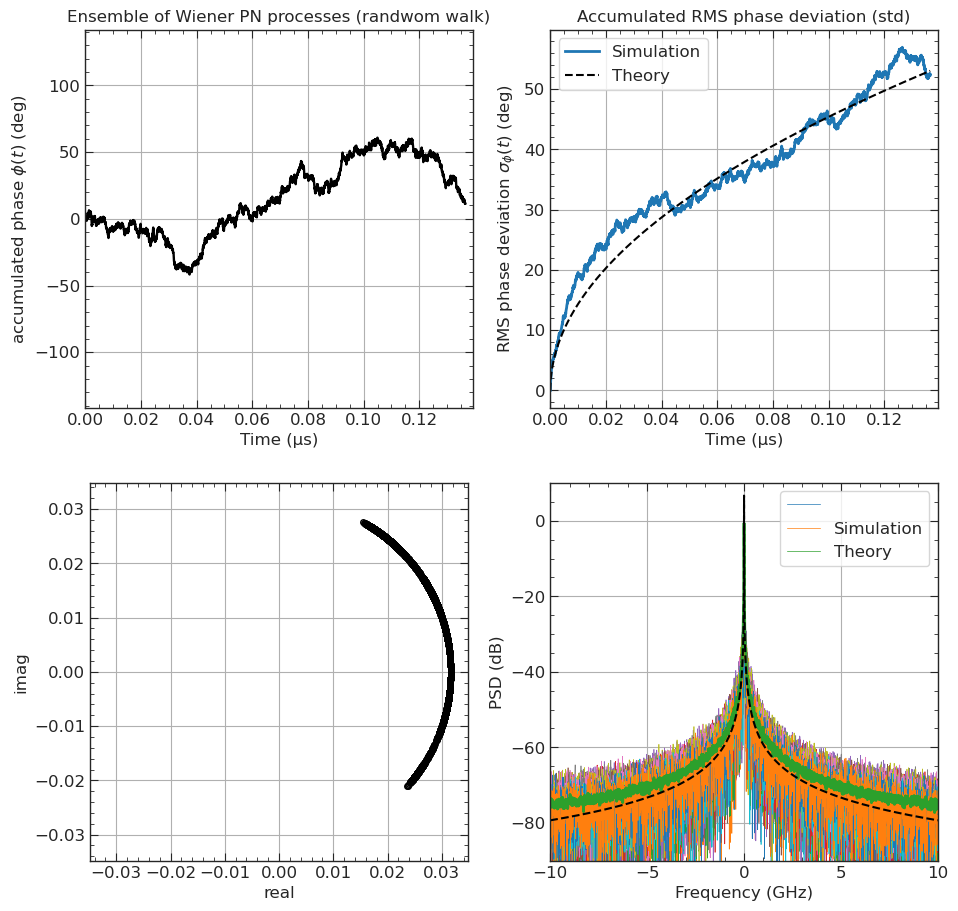

In [12]:
### plotting
n_row = 2; n_col = 2
#fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig_size = [11,11]
fig = plt.figure(figsize=fig_size)

## plot of phase random walk (and last process again in black)
ax = fig.add_subplot(n_row, n_col, 1);
#ax.plot(t/1e-6, 180/m.pi*phaseAcc[:,0::1], linewidth=0.4);
ax.plot(t/1e-6, 180/m.pi*phaseAcc[:,-1], linewidth=1.7, color='k'); # only last column (one sample function of random walk ensamble)
absMaxPh = 1.05 * m.degrees(np.max(np.abs(phaseAcc)))
ax.set(xlabel='Time (µs)', xlim=(0,1.02*np.max(t)/1e-6), ylabel='accumulated phase $\phi(t)$ (deg)',ylim=(-absMaxPh,absMaxPh))
plt.title('Ensemble of Wiener PN processes (randwom walk)')

## plot of phase standard-deviation vs. time (averaged over all sample processes)
ax = fig.add_subplot(n_row, n_col, 2)
ax.plot(t/1e-6, 180/m.pi*np.sqrt(varMeas));
ax.plot(t/1e-6,  180/m.pi*np.sqrt(varPN*np.arange(0,M)), linewidth=1.5, color='k', linestyle='dashed')
ax.set(xlabel='Time (µs)', xlim=(0,1.02*np.max(t)/1e-6), ylabel='RMS phase deviation $\sigma_\phi(t)$ (deg)'); # ylim=(-20, 20)
plt.title('Accumulated RMS phase deviation (std)')
ax.legend(('Simulation','Theory'))

## plot of imag-vs-real of last sample process
ax = fig.add_subplot(n_row, n_col, 3)
absMaxMag = 1.1 * np.max(np.abs(x))
#ax.plot(t/1e-6,  x.real, linewidth=1.5, color='k')
#ax.plot(t/1e-6,  x.imag, linewidth=1.5, color='r')
ax.plot(x.real[:,-1],  x.imag[:,-1], 'ok', mfc='none', ms=4); plt.axis('square');
ax.set(xlabel='real',xlim=(-absMaxMag,absMaxMag), ylabel='imag',ylim=(-absMaxMag,absMaxMag)); # ylim=(-20, 20)
#plt.title('Accumulated RMS phase deviation (std)')
#ax.legend(('theory','simulation'));

## plot of PSD averaged over all ensemble members + theoretical Lorenzian PSD

ax = fig.add_subplot(n_row, n_col, 4)
#ax.plot(fftshift(ACF.real))
ax.plot(freq/1e9,10*np.log10(PSD/1e-3),linewidth=0.5);
ax.plot(freq/1e9,10*np.log10(np.mean(PSD,axis=1)/1e-3) );
ax.plot(freq/1e9, 10*np.log10(Sx/1e-3), linewidth=1.5, color='k', linestyle='dashed');

ax.set(xlabel='Frequency (GHz)',xlim=(-10,10), ylabel='PSD (dB)',ylim=(-90,10+10*np.log10(Ps/1e-3))); # ylim=(-20, 20)
ax.legend(('Simulation','Theory'));

In [9]:
l = freq==0
result = np.where(l)
print(result[0])
print(freq.argmin())
print(np.max(Sx))

[2048]
0
0.004662742473395372
